# Unlock the Power of Super-Resolution with the Super Resolution Convolutional Neural Network (SRCNN) for Image Restoration

Welcome to an exciting journey into the world of single-image super-resolution (SR)! Imagine being able to transform a blurry, low-resolution image into a crisp, high-resolution masterpiece – or as they say on crime dramas, simply *enhance*!

In this tutorial, we'll dive into the process of deploying the Super-Resolution Convolutional Neural Network (SRCNN) using Keras. This cutting-edge network, introduced in the 2014 paper [*Image Super-Resolution Using Deep Convolutional Networks*](https://arxiv.org/abs/1501.00092) by Chao Dong and colleagues, provides a deep learning approach to reconstruct high-resolution images from low-resolution ones.

As the name suggests, SRCNN is a powerful deep convolutional neural network that learns to map low-resolution images to high-resolution outputs. In this tutorial, we’ll explore how this technique can significantly enhance image quality. To evaluate the network's performance, we’ll use three key image quality metrics: Peak Signal-to-Noise Ratio (PSNR), Mean Squared Error (MSE), and Structural Similarity Index (SSIM).

Additionally, we’ll leverage **OpenCV** – the powerful open-source computer vision library developed by Intel – to pre-process and post-process our images. Throughout this project, you’ll see how we’ll convert images between RGB, BGR, and YCrCb color spaces. This is essential since SRCNN was trained on the luminance (Y) channel in the YCrCb space.

By the end of this project, you’ll gain hands-on experience in:

- Mastering image quality metrics like PSNR, MSE, and SSIM
- Using OpenCV for advanced image processing
- Converting between different color spaces (RGB, BGR, YCrCb)
- Building and deploying deep neural networks with Keras
- Evaluating the performance of SRCNN to boost image quality


## 1. Importing Packages

Let's get started! In this first cell, we'll import the libraries and packages we'll be using throughout the project and display their version numbers. This step is crucial to ensure consistency and will help others replicate the results we achieve.

In [1]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Keras: 3.6.0
OpenCV: 4.10.0
NumPy: 1.26.4
Matplotlib: 3.9.2
Scikit-Image: 0.24.0


In [2]:
# import the necessary packages
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D
from keras._tf_keras.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

## 2. Image Quality Metrics

Let's begin by defining a few functions to compute PSNR, MSE, and SSIM. While the Structural Similarity Index (SSIM) is directly imported from the scikit-image library, we will need to define our own functions for calculating PSNR and MSE. Additionally, we will consolidate all three metrics into a single function for easy future use.

In [3]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def compare_images(target, ref):
    # initialize an empty list to store the scores
    scores = []
    
    # calculate PSNR
    psnr = cv2.PSNR(target, ref)
    scores.append(psnr)
    
    # calculate MSE
    mse = ((target - ref) ** 2).mean()
    scores.append(mse)
    
    # calculate SSIM
    # set a smaller window size if images are small
    scores.append(ssim(target, ref, multichannel=True, win_size=3))
    
    return scores

## 3. Preparing Images

For this project, we will use the same images that were utilized in the original SRCNN paper. These images can be downloaded from http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html. The .zip file labeled as the MATLAB code contains the images we need. Copy both the Set5 and Set14 datasets into a new folder named 'source'.

After obtaining the images, we will generate low-resolution versions by resizing them, both downwards and upwards, using OpenCV. Various interpolation methods are available for resizing images, but we will use bilinear interpolation for this task.

Once the low-resolution images are created, we will save them in a new folder.

In [4]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(os.path.join(path, file))
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img_down = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # resize the image - up
        img_up = cv2.resize(img_down, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # save the image
        print(f'Saving {file}')
        cv2.imwrite(os.path.join('images', file), img_up)

In [5]:
prepare_images('source/', 2)

Saving Camman256B.bmp
Saving Clown256B.bmp
Saving Fruit256B.bmp
Saving Lena256B.bmp
Saving Odie256B.bmp
Saving Zone256B.bmp


## 4. Testing Low Resolution Images

To verify that our image quality metrics are being calculated accurately and that the images have been properly degraded, let's compute the PSNR, MSE, and SSIM between the reference images and the degraded images we just generated.

In [6]:
# Now, test the images using the updated function
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

Camman256B.bmp
PSNR: 25.109354454817307
MSE: 32.77972412109375
SSIM: 0.8002243011595996

Clown256B.bmp
PSNR: 28.647013364181536
MSE: 37.316497802734375
SSIM: 0.8489471550507903

Fruit256B.bmp
PSNR: 33.78124545690424
MSE: 18.1109619140625
SSIM: 0.9053057857824421

Lena256B.bmp
PSNR: 28.502128334571974
MSE: 29.613845825195312
SSIM: 0.842458470617191

Odie256B.bmp
PSNR: 23.554814078393903
MSE: 9.215423583984375
SSIM: 0.9231342767094544

Zone256B.bmp
PSNR: 10.452225504937914
MSE: 101.86917114257812
SSIM: 0.31964361464552327



## 5.Building the SRCNN Model

Now that we have the low-resolution images and all three image quality metrics working correctly, we can begin constructing the SRCNN. In Keras, this is done by sequentially adding layers. The architecture and hyperparameters of the SRCNN network can be found in the publication referenced earlier.

In [7]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(learning_rate=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

## 6.Deploying the SRCNN

Now that we have defined our model, we can use it for single-image super-resolution. However, before we do this, we will need to define a couple of image processing functions. Furthermore, it will be necessary to preprocess the images extensively before using them as inputs to the network. This processing will include cropping and color space conversions.

Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN. These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras

Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side.

In [8]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [9]:
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

C:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Degraded Image: 
PSNR: 28.204414144356402
MSE: 31.24808692990511
SSIM: 0.8338730442838407

Reconstructed Image: 
PSNR: 31.484106037550678
MSE: 21.576352753120428
SSIM: 0.8891781801492074



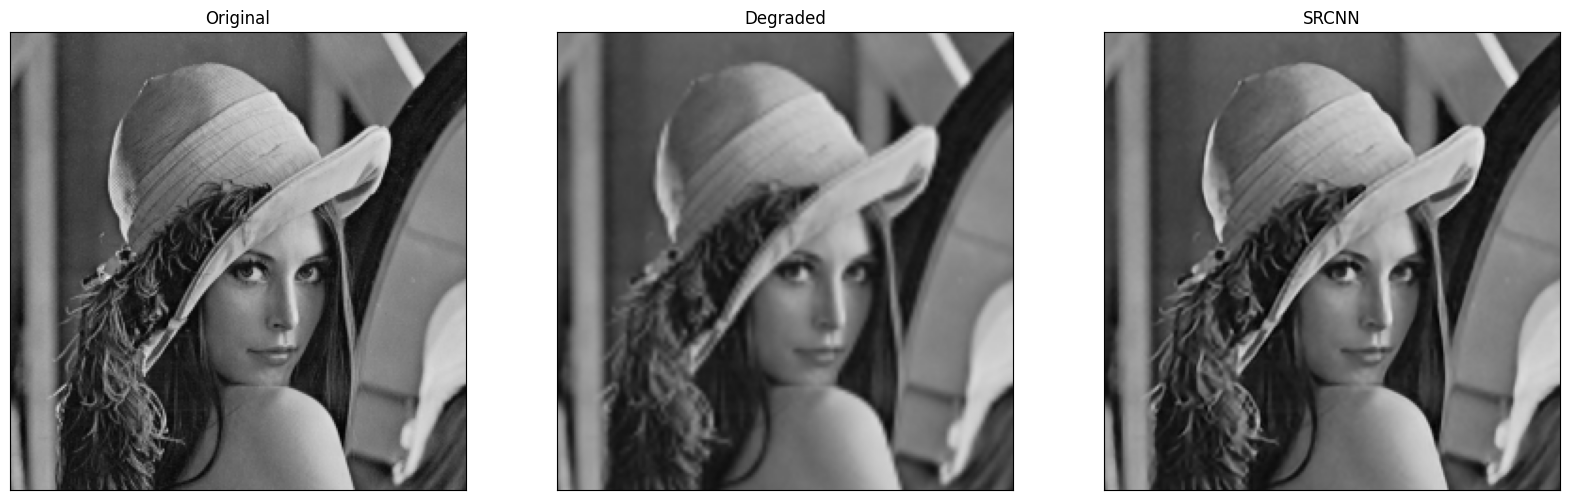

In [10]:
ref, degraded, output, scores = predict('images/Lena256B.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
# Ensure the output directory exists
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for file in os.listdir('images'):
    
    # Perform super-resolution (assuming the 'predict' function is defined elsewhere)
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # Display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel='PSNR: {}\nMSE: {}\nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel='PSNR: {}\nMSE: {}\nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # Remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    # Save the figure to the 'output' folder
    print('Saving {}'.format(file))
    fig.savefig(os.path.join(output_dir, '{}.png'.format(os.path.splitext(file)[0]))) 
    plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Saving Camman256B.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Saving Clown256B.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Saving Fruit256B.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Saving Lena256B.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Saving Odie256B.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Saving Zone256B.bmp
